<a href="https://colab.research.google.com/github/tumbler-lab/AutoEncoder/blob/main/ConvolutionalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor() # tensor

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [ ]:
num_workers = 4
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Definition

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoEncoder(nn.Module):
    def __init__(self, z_dim):
        super(ConvAutoEncoder, self).__init__()
        ## encoder Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # poolした場所おぼえる
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True)
        self.linear1 = nn.Linear(7*7*32, z_dim)

        ## decoder Layer
        # convtransposeはconvの逆
        self.t_conv1 =  nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.t_conv2 =  nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        
        self.unpool1 = nn.MaxUnpool2d(2, 2)
        self.unpool2 = nn.MaxUnpool2d(2, 2)
        self.tlinear1 = nn.Linear(z_dim, 7*7*32)

    
    def encode(self, x):
        ## encode
        x = F.relu(self.conv1(x))
        x, a = self.pool1(x)
        x = F.relu(self.conv2(x))
        x, b = self.pool2(x)
        x = x.view(-1, 7*7*32)
        x = F.relu(self.linear1(x))
        return x, a, b

    def decode(self, x, a, b):
        ## decode
        x = F.relu(self.tlinear1(x))
        x = x.view(-1, 32, 7, 7)
        x = self.unpool1(x, b)
        x = F.relu(self.t_conv1(x))
        x = self.unpool2(x, a)
        x = torch.sigmoid(self.t_conv2(x))
        return x


    def forward(self, x):
        z, a, b = self.encode(x)
        x = self.decode(z, a, b)
        
        return x, z


# Training

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ConvAutoEncoder(2).to(device)
print(model)
# loss function
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

ConvAutoEncoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1568, out_features=2, bias=True)
  (t_conv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (unpool1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (unpool2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (tlinear1): Linear(in_features=2, out_features=1568, bias=True)
)


In [ ]:
list_z = [] # zのリスト
list_label = [] # label list
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for data in train_loader:
        optimizer.zero_grad() # 重み初期化
        
        images, label = data
        images = images.to(device)
        outputs, z = model(images)
        list_z.append(z)
        list_label.append(label)
        loss = criterion(outputs, images) # 生成した画像と元の画像の差異

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 	Training Loss: 0.021539
Epoch: 2 	Training Loss: 0.006735
Epoch: 3 	Training Loss: 0.005885
Epoch: 4 	Training Loss: 0.005661
Epoch: 5 	Training Loss: 0.005392
Epoch: 6 	Training Loss: 0.005351
Epoch: 7 	Training Loss: 0.005271
Epoch: 8 	Training Loss: 0.005292
Epoch: 9 	Training Loss: 0.005292
Epoch: 10 	Training Loss: 0.005280
Epoch: 11 	Training Loss: 0.005320
Epoch: 12 	Training Loss: 0.005260
Epoch: 13 	Training Loss: 0.005299
Epoch: 14 	Training Loss: 0.005293
Epoch: 15 	Training Loss: 0.005385
Epoch: 16 	Training Loss: 0.005649
Epoch: 17 	Training Loss: 0.005837
Epoch: 18 	Training Loss: 0.006043
Epoch: 19 	Training Loss: 0.006214
Epoch: 20 	Training Loss: 0.006294
Epoch: 21 	Training Loss: 0.006256
Epoch: 22 	Training Loss: 0.006343
Epoch: 23 	Training Loss: 0.006602
Epoch: 24 	Training Loss: 0.006638
Epoch: 25 	Training Loss: 0.006631
Epoch: 26 	Training Loss: 0.006776
Epoch: 27 	Training Loss: 0.006870
Epoch: 28 	Training Loss: 0.006863
Epoch: 29 	Training Loss: 0.0

In [ ]:
list_z_test = [] # zのリスト
list_label_test = [] # label list
model.eval()
for data in test_loader:
    images, label = data
    images = images.to(device)
    outputs, z = model(images)
    list_z_test.append(z)
    list_label_test.append(label)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
array_z_test = np.concatenate([z.cpu().detach().numpy().copy() for z in list_z_test])
display(array_z_test)
array_label_test = np.concatenate([z.cpu().detach().numpy().copy() for z in list_label_test])
display(array_label_test)

array([[0.       , 3.3192012],
       [0.       , 3.1994882],
       [0.       , 3.8494701],
       ...,
       [0.       , 2.8926153],
       [0.       , 3.0342298],
       [0.       , 2.6172233]], dtype=float32)

array([7, 2, 1, ..., 4, 5, 6])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


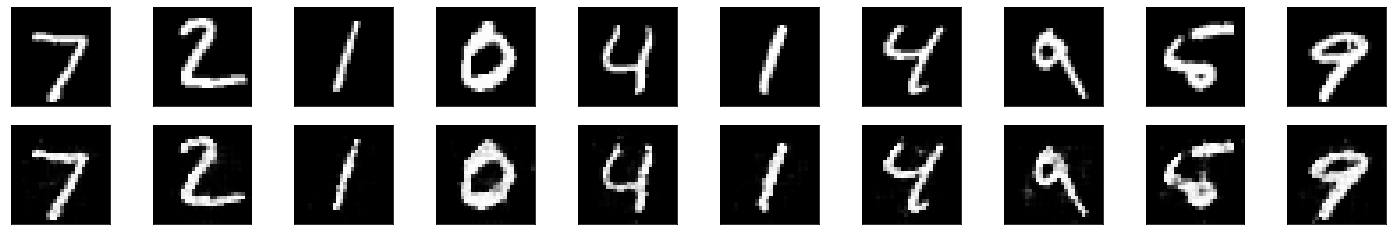

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)

output, _ = model(images)
images = images.view(batch_size, 1, 28, 28)
images = images.cpu().numpy()


output = output.view(batch_size, 1, 28, 28)
output = output.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25, 4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


# 2次元プロット

In [ ]:
def get_mean(z_mu, y_sample, num):
    for i in range(10):
        idx = y_sample==num
    return np.mean(z_mu[idx], axis=0)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


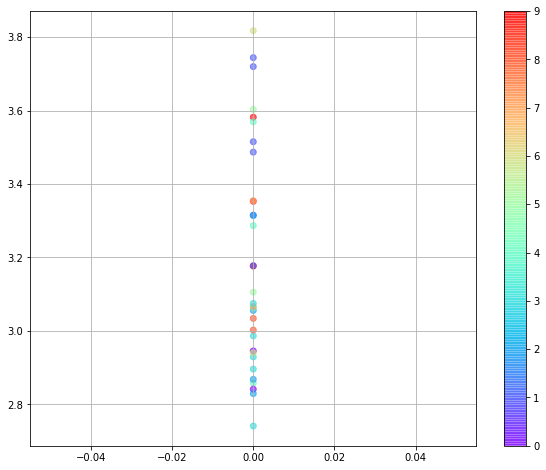

In [ ]:
import matplotlib.pyplot as plt

dataiter =iter(train_loader)
image_sample, label_sample = dataiter.next()
image_sample = image_sample.to(device)
z_mu, a, b = model.encode(image_sample)
z_mu = z_mu.view(32,-1).detach().cpu().numpy().copy()

plt.figure(figsize=(10, 8)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=label_sample, cmap="rainbow", alpha=0.6)
# for i in range(10):
#     m = get_mean(z_mu, label_sample, i)
#     plt.text(m[0], m[1], "{}".format(i), fontsize=20)

plt.colorbar()
plt.grid()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  if sys.path[0] == '':


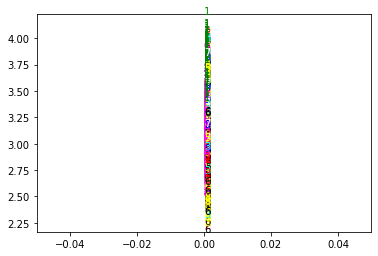

In [ ]:
import matplotlib.pyplot as plt

# dataiter =iter(train_loader)
# image_sample, label_sample = dataiter.next()
# image_sample = image_sample.to(device)
# z_mu, a, b = model.encode(image_sample)
# z_mu = z_mu.view(32,-1).detach().cpu().numpy().copy()
z_mu = array_z_test.copy()
# z_mu[:, 1] = 1

idx1, idx2 = 0, 1
plt.xlim(z_mu[:, idx1].min(), z_mu[:, idx1].max())
plt.ylim(z_mu[:, idx2].min(), z_mu[:, idx2].max())
color_dict = {0: 'blue', 1: 'green', 2: 'red', 3: 'cyan',
              4: 'magenta', 5: 'yellow', 6: 'black', 7: 'white', 8: 'yellow', 9: 'blue'}
for z, label in zip(z_mu, array_label_test):
    if label:
        plt.text(z[idx1], z[idx2], s=label.item(), color=color_dict[label.item()])
plt.show()

In [ ]:
z_mu

array([[0.        , 1.        ],
       [0.04281466, 1.        ],
       [0.02756484, 1.        ],
       ...,
       [1.9277858 , 1.        ],
       [1.859339  , 1.        ],
       [1.8220985 , 1.        ]], dtype=float32)

# いみふめい

In [ ]:
"dataiter =iter(train_loader)

len(dataiter.next()[0])

In [ ]:
z_mu.reshape((1000)).shape

In [ ]:
test_dataset = datasets.MNIST('./data', download=True, train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)
test_images, test_labels = iter(test_loader).next()
#test_images = test_images.view(1000, -1)

with torch.no_grad():
    #batch_size=10000
    z = model.encode(test_images.to(device))
test_mu, test_logvar = z
test_mu = test_mu.to(device)
test_mu = test_mu.cpu()
test_mu = test_mu.detach().numpy()

import pylab
import matplotlib.pyplot as plt
%matplotlib inline

#VAEの潜在変数にラベルをつけてプロット
plt.figure(figsize=(10, 10))
plt.scatter(test_mu[:, 0], test_mu[:, 1], marker='.', c=test_labels, cmap=pylab.cm.jet)
plt.colorbar()
plt.xlim((-6, 6))
plt.ylim((-6, 6))
plt.title("VAE")

ValueError: ignored

In [ ]:
# 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
z_df = pd.DataFrame(z_mu)

feature_corr = z_df.corr()
fig, ax = plt.subplots(figsize=(12, 9)) 
sns.heatmap(feature_corr, square=True, vmax=1, vmin=-1, center=0)


In [ ]:
z_mu.shape

In [ ]:
train_data.data.size()